# Key References
- Basic theory of A-S model: https://www.researchgate.net/publication/24086205_High_Frequency_Trading_in_a_Limit_Order_Book
- Simple implementation of A-S model: https://github.com/fedecaccia/avellaneda-stoikov

- A more realistic implementation of A-S model, integrating inventory risk control and trade simulation: https://stanford.edu/class/msande448/2018/Final/Reports/gr5.pdf

# Which Data To Use 
- Please use the data in `data/resampled`
- Data frequency: 1s

- 5 coin-pairs x 7 days x 86400s
  - BTC/USDT spot
  - ETH/BTC spot
  - BTC/USDC spot
  - BTC/USD spot
  - BTC/USDT swap


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression

## 0. Data pre-processing. Can skip.
- Please directly use the pre-processed data under `data/resampled`. No need to go through this part again.

- Raw data (order book history, depth=50, freq=10ms) not uploaded due to file size constrain. Can manually download from OKX if needed. https://www.okx.com/en-sg/data-download?type=1

- Binance only provides real-time order book data. Suitable for live trading. https://testnet.binance.vision/

- No historical order book data found on Binance. https://github.com/binance/binance-public-data

In [ ]:
## Check what raw data looks like
raw_file_path = "data/raw/BTC-USDT_2025-09-20.csv.gz"
pd.read_csv(raw_file_path, compression='gzip', nrows = 10)

,timeMs,exchTimeMs,bid_1_px,bid_1_qty,bid_1_ordCnt,ask_1_px,ask_1_qty,ask_1_ordCnt,bid_2_px,bid_2_qty,...,ask_49_px,ask_49_qty,ask_49_ordCnt,bid_50_px,bid_50_qty,bid_50_ordCnt,ask_50_px,ask_50_qty,ask_50_ordCnt,symbol
0,1758326400008,1758326400005,115630,1.780441,25,115630.1,0.014552,1,115629.9,0.402935,...,115650.4,0.001729,1,115612.0,0.010727,2,115650.8,0.000079,7,BTC-USDT.OK
1,1758326400028,1758326400015,115630,1.780441,25,115630.1,0.014552,1,115629.9,0.402935,...,115650.4,0.001729,1,115612.0,0.010727,2,115650.8,0.000079,7,BTC-USDT.OK
2,1758326400031,1758326400025,115630,1.780441,25,115630.1,0.014469,1,115629.9,0.402935,...,115650.4,0.001729,1,115612.0,0.010727,2,115650.8,0.000079,7,BTC-USDT.OK
3,1758326400036,1758326400035,115630,1.780441,25,115630.1,0.014469,1,115629.9,0.402935,...,115650.4,0.001729,1,115612.0,0.010727,2,115650.8,0.000079,7,BTC-USDT.OK
4,1758326400076,1758326400075,115630,1.780441,25,115630.1,0.014469,1,115629.9,0.402935,...,115650.4,0.001729,1,115612.0,0.010727,2,115650.8,0.000079,7,BTC-USDT.OK
5,1758326400086,1758326400085,115630,1.780441,25,115630.1,0.014469,1,115629.9,0.402935,...,115650.4,0.001729,1,115612.0,0.010727,2,115650.8,0.000079,7,BTC-USDT.OK
6,1758326400096,1758326400095,115630,1.780441,25,115630.1,0.014469,1,115629.9,0.402935,...,115650.3,0.000010,1,115612.0,0.010727,2,115650.4,0.001729,1,BTC-USDT.OK
7,1758326400106,1758326400105,115630,1.780441,25,115630.1,0.014469,1,115629.9,0.402935,...,115650.3,0.000010,1,115612.0,0.010727,2,115650.4,0.001729,1,BTC-USDT.OK
8,1758326400116,1758326400115,115630,1.780441,25,115630.1,0.014469,1,115629.9,0.402935,...,115650.3,0.000010,1,115612.0,0.010727,2,115650.4,0.001729,1,BTC-USDT.OK
9,1758326400136,1758326400135,115630,1.780362,24,115630.1,0.014469,1,115629.9,0.402935,...,115650.3,0.000010,1,115612.3,0.001853,1,115650.4,0.001729,1,BTC-USDT.OK


In [ ]:
## Resample order book data from 10ms to 1s. 86400 rows per day
def resample_data(csv_path, freq="1s", save_result=True):
    df = pd.read_csv(csv_path, compression='gzip')
    # Convert timeMs to datetime; OKX uses milliseconds
    df["event_time"] = pd.to_datetime(df["timeMs"], unit="ms", utc=True)
    df_resampled = (df.set_index("event_time")
             .resample(freq)
             .last())
    if save_result:
        symbol = df_resampled['symbol'].iloc[0].split('.')[0]
        dt = df_resampled.index[0].strftime('%Y-%m-%d')
        output_csv_path = f'data/resampled/{symbol}_{dt}.csv.gz'
        df_resampled.to_csv(output_csv_path, compression='gzip')
        print(f"File saved to {output_csv_path}")
    
    return df_resampled

In [12]:
# df = resample_data("data/raw/BTC-USD_2025-09-20.csv.gz")
# df.head()

## Time consuming. No need to run again. Results already saved to data/resampled 
for file_name in os.listdir("data/raw"):
    df = resample_data(f"data/raw/{file_name}", freq="1s", save_result=True)

File saved to data/resampled/BTC-USD_2025-09-18.csv.gz
File saved to data/resampled/BTC-USD_2025-09-14.csv.gz
File saved to data/resampled/ETH-BTC_2025-09-18.csv.gz
File saved to data/resampled/ETH-BTC_2025-09-14.csv.gz
File saved to data/resampled/BTC-USDC_2025-09-20.csv.gz
File saved to data/resampled/BTC-USDC_2025-09-16.csv.gz
File saved to data/resampled/BTC-USDC_2025-09-18.csv.gz
File saved to data/resampled/BTC-USDC_2025-09-14.csv.gz
File saved to data/resampled/BTC-USD_2025-09-16.csv.gz
File saved to data/resampled/ETH-BTC_2025-09-20.csv.gz
File saved to data/resampled/ETH-BTC_2025-09-16.csv.gz
File saved to data/resampled/BTC-USD_2025-09-20.csv.gz
File saved to data/resampled/BTC-USDT-SWAP_2025-09-20.csv.gz
File saved to data/resampled/BTC-USDT_2025-09-19.csv.gz
File saved to data/resampled/BTC-USDT_2025-09-15.csv.gz
File saved to data/resampled/BTC-USDT-SWAP_2025-09-16.csv.gz
File saved to data/resampled/BTC-USDT-SWAP_2025-09-14.csv.gz
File saved to data/resampled/BTC-USDT_202

## 1. Data prep

In [ ]:
## Calculate mid price and vol
def load_data(csv_path, keep_all_cols=False):
    # Basic sanity checks (columns must exist)
    df = pd.read_csv(csv_path, index_col="event_time", compression='gzip')
    required = ["bid_1_px","ask_1_px","bid_1_qty","ask_1_qty"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    if not keep_all_cols: # no need for data from all 50 depths
        df = df[required]
    df["mid"] = (df["bid_1_px"] + df["ask_1_px"]) / 2.0
    df["spread"] = df["ask_1_px"] - df["bid_1_px"]
    # Realized vol proxy
    df["ret"] = np.log(df["mid"]).diff()
    # 5min rolling average vol
    df["sigma"] = df["ret"].rolling(300, min_periods=60).std()
    # Order book imbalance. not required by the base model but might be useful for vol forecast
    df["obi"] = (df["bid_1_qty"] - df["ask_1_qty"]) / (df["bid_1_qty"] + df["ask_1_qty"])
    df = df.dropna(subset=["mid","sigma"])
    return df

In [ ]:
## Model input - 1 day for demo
resampled_file_path = "data/resampled/BTC-USDT_2025-09-20.csv.gz"
order_book = load_data(resampled_file_path)
order_book.head(30)

,bid_1_px,ask_1_px,bid_1_qty,ask_1_qty,mid,spread,ret,sigma,obi
event_time,,,,,,,,,
2025-09-20 00:01:00+00:00,115610.0,115610.1,1.029554,0.635480,115610.05,0.1,0.000000,0.000021,0.236676
2025-09-20 00:01:01+00:00,115610.0,115610.1,0.297905,1.137391,115610.05,0.1,0.000000,0.000021,-0.584887
2025-09-20 00:01:02+00:00,115610.0,115610.1,0.492882,1.207289,115610.05,0.1,0.000000,0.000020,-0.420197
2025-09-20 00:01:03+00:00,115610.0,115610.1,0.673032,0.674084,115610.05,0.1,0.000000,0.000020,-0.000781
2025-09-20 00:01:04+00:00,115610.0,115610.1,0.661696,0.700193,115610.05,0.1,0.000000,0.000020,-0.028268
2025-09-20 00:01:05+00:00,115610.0,115610.1,0.866226,0.800193,115610.05,0.1,0.000000,0.000020,0.039625
2025-09-20 00:01:06+00:00,115610.0,115610.1,0.866226,0.800217,115610.05,0.1,0.000000,0.000020,0.039610
2025-09-20 00:01:07+00:00,115610.0,115610.1,0.866226,0.730319,115610.05,0.1,0.000000,0.000020,0.085125
2025-09-20 00:01:08+00:00,115610.0,115610.1,0.881696,0.728505,115610.05,0.1,0.000000,0.000019,0.095137


## 2. Market Making Simulation

In [ ]:
## Historical LOB replay, easily scale to live trading
class OrderBookFeed:
    def __init__(self, df):
        self.df = df
        self.i = 0
        self.n = len(df)

    def reset(self):
        self.i = 0

    def done(self):
        return self.i >= self.n

    def step(self):
        """Return current L1 snapshot and advance."""
        row = self.df.iloc[self.i]
        self.i += 1
        return {
            "bid_px": float(row.bid_1_px),
            "ask_px": float(row.ask_1_px),
            "bid_qty": float(row.bid_1_qty),
            "ask_qty": float(row.ask_1_qty),
            "mid": float(row.mid),
            "spread": float(row.spread),
            "sigma": float(row.sigma) if np.isfinite(row.sigma) else np.nan,
        }

In [ ]:
## TODO How to calibrate intensity function - will affect the value of k plugged into the simulator
## Intensity function. from paper (Section 3.1) https://stanford.edu/class/msande448/2018/Final/Reports/gr5.pdf

# def intensity(delta, sigma_t, A=0.5, k=0.5, beta=0.8, sigma0=1e-5):
#     """ λ = A * exp(-k*delta) * (sigma_t/sigma0)**beta """
#     sratio = max(sigma_t / max(sigma0, 1e-12), 1e-8)
#     return A * np.exp(-k * max(delta, 0.0)) * (sratio ** beta)

# def calibrate_intensity(df):

#     def prep_calib_data(df, gamma=0.1, tau=1.0, k_spread=0.5, tick=0.1):
#         S = df["mid"].to_numpy()
#         sig = df["sigma"].to_numpy()
#         half_spreads = []
#         for s, sg in zip(S, sig):
#             _, _, _, hs = avellaneda_stoikov_quotes(s, q=0.0, sigma=sg, gamma=gamma, tau=tau, k=k_spread, mu_pred=0.0, tick=tick)
#             half_spreads.append(hs)
#         delta = np.array(half_spreads)
#         ret = df["ret"].to_numpy()
#         mo_proxy = np.abs(ret) / (tick / max(S.mean(), 1.0))
#         mo_proxy = np.nan_to_num(mo_proxy, nan=0.0, posinf=0.0, neginf=0.0)
#         mo_proxy = pd.Series(mo_proxy).ewm(span=5, adjust=False).mean().to_numpy()
#         calib_df = pd.DataFrame({
#             "delta": delta,
#             "sigma": sig,
#             "count": mo_proxy
#         })
#         return calib_df
    
#     calib_df = prep_calib_data(df)

#     eps = 1e-6
#     sigma0 = float(np.median(calib_df["sigma"].values))
#     y = np.log(calib_df["count"].values + eps)
#     X = np.column_stack([
#         -calib_df["delta"].values,
#         np.log((calib_df["sigma"].values + 1e-12) / max(sigma0, 1e-12))
#     ])
#     lr = LinearRegression().fit(X, y)
#     logA = lr.intercept_
#     k = -float(lr.coef_[0])
#     beta = float(lr.coef_[1])
#     A = float(np.exp(logA))
#     return A, k, beta, sigma0


In [ ]:
## Market making simulator
class MMSimulator:
    ## TODO How to calibrate gamma
    def __init__(self, feed, gamma=20, k=8, tau=1.0, lot=0.01, max_inv=5.0):
        self.feed = feed
        self.gamma = gamma # risk aversion coefficient
        self.k = k # how fast intensity decays with delta depth
        self.tau = tau  # length of limit time horizon
        self.lot = lot # min trade size
        self.max_inv = max_inv # max inventory affordable by the market maker
        self.q = 0.0 # order size
        self.cash = 0.0
        self.inv = 0.0 # current inventory
        self.px_bid = None
        self.px_ask = None
        self.history = []

    def get_order_size(self):
        # simple inventory-aware sizing - shrink as |inv| grows
        scale = max(0.2, 1.0 - abs(self.inv)/self.max_inv)
        return round(self.lot * (1.0 + 4.0*scale), 4)
    
    ## TODO Alternative inventory-aware sizing from paper (Section 2.2) https://stanford.edu/class/msande448/2018/Final/Reports/gr5.pdf
    # def get_order_size(self, phi_max=10.0, eta=0.05):
    #     if self.q <= 0:  # short/flat -> ok to buy, shrink sells
    #         return phi_max, phi_max * np.exp(-eta * abs(self.q))
    #     else:       # long -> ok to sell, shrink buys
    #         return phi_max * np.exp(-eta * abs(self.q)), phi_max

    ## A-S model from paper https://www.researchgate.net/publication/24086205_High_Frequency_Trading_in_a_Limit_Order_Book
    def get_as_quotes(self, mid, sigma, drift=0.0):
        # reservation price (basic A–S; add drift/skew if you have view on price moving direction)
        r_t = mid - self.q * self.gamma * (sigma**2) * self.tau
        # optimal half-spread (classic closed form)
        half_spread = (1.0/self.k) * np.log(1.0 + self.k/self.gamma) + 0.5 * self.gamma * (sigma**2) * self.tau
        bid = (r_t - half_spread)
        ask = (r_t + half_spread)
        return bid, ask

    def step(self):
        snap = self.feed.step()
        mid, sigma = snap["mid"], 0.0 if np.isnan(snap["sigma"]) else snap["sigma"] # where forecast vol comes in. now in baseline model we use historical vol
        # TODO re-arrange the code to easily plug forecast models in later
        
        # quotes
        self.px_bid, self.px_ask = self.get_as_quotes(mid, sigma)

        # simulate fills against live top-of-book
        sz = self.get_order_size()
        # hit if we quote at or better than best bid, and the mid ticks down, we assume a fill
        if self.px_bid >= snap["bid_px"] and snap["bid_qty"] > 0 and self.inv + sz <= self.max_inv:
            trade_px = snap["bid_px"]
            trade_sz = min(sz, snap["bid_qty"])
            self.inv += trade_sz
            self.cash -= trade_sz * trade_px
        # lift if we quote at or better than best ask, and the mid ticks up, we assume a fill
        if self.px_ask <= snap["ask_px"] and snap["ask_qty"] > 0 and self.inv - sz >= -self.max_inv:
            trade_px = snap["ask_px"]
            trade_sz = min(sz, snap["ask_qty"])
            self.inv -= trade_sz
            self.cash += trade_sz * trade_px
        
        # TODO Alternatively, integrate intensity function for order-fill simulation

        mtm = self.cash + self.inv * mid
        self.history.append((mid, self.px_bid, self.px_ask, self.inv, mtm))
        return snap

    def run(self):
        self.feed.reset()
        while not self.feed.done():
            self.step()
        return pd.DataFrame(self.history, columns=["mid","px_bid","px_ask","inv","pnl"])


## 3. Performance

In [ ]:
## Main function
feed = OrderBookFeed(order_book)
mm = MMSimulator(feed)
res = mm.run()
res.tail(30)

,mid,px_bid,px_ask,inv,pnl
86310,115685.95,115685.907941,115685.992059,4.976285,547.72652
86311,115685.95,115685.907941,115685.992059,4.976285,547.72832
86312,115685.95,115685.907941,115685.992059,4.976285,547.73012
86313,115685.95,115685.907941,115685.992059,4.976285,547.73192
86314,115685.95,115685.907941,115685.992059,4.976285,547.73372
86315,115685.95,115685.907941,115685.992059,4.976285,547.73552
86316,115685.95,115685.907941,115685.992059,4.976285,547.73732
86317,115685.95,115685.907941,115685.992059,4.976285,547.73912
86318,115685.95,115685.907941,115685.992059,4.976285,547.74092
86319,115685.95,115685.907941,115685.992059,4.976285,547.74272


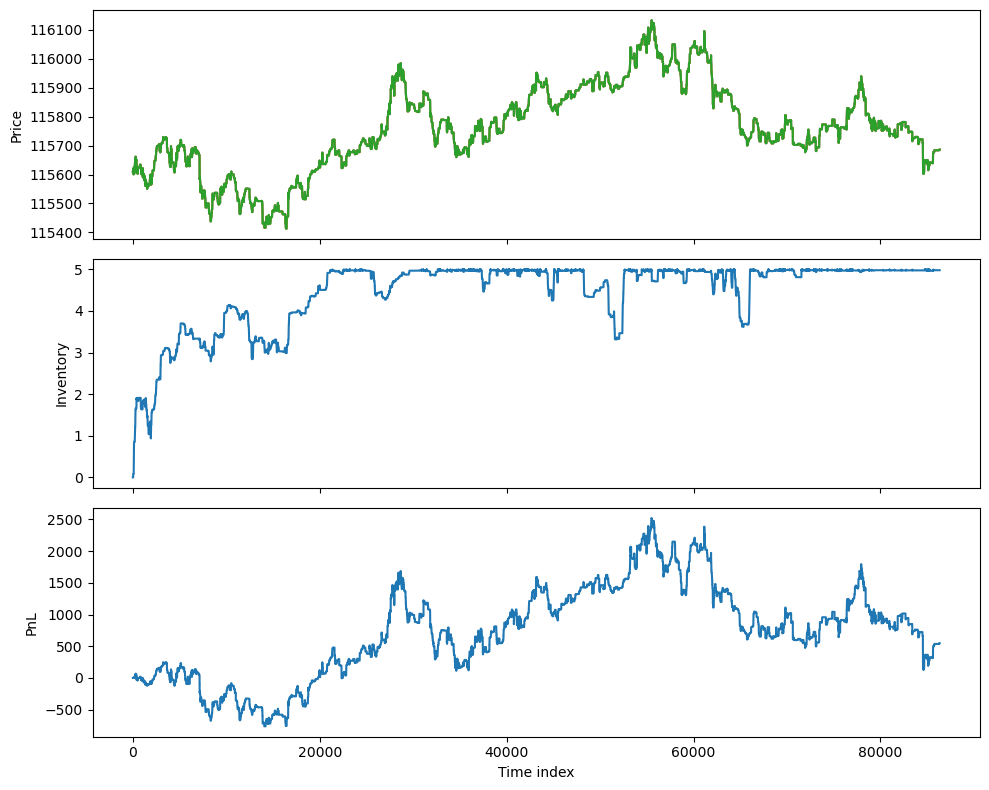

In [ ]:
## Plots (price, inventory, PnL)
fig, axes = plt.subplots(3, 1, figsize=(10,8), sharex=True)
axes[0].plot(res["mid"]); axes[0].plot(res["px_bid"]); axes[0].plot(res["px_ask"]); axes[0].set_ylabel("Price")
axes[1].plot(res["inv"]); axes[1].set_ylabel("Inventory")
axes[2].plot(res["pnl"]); axes[2].set_ylabel("PnL"); axes[2].set_xlabel("Time index")
plt.tight_layout(); plt.show()

## TODO Plot hourly(?) PnL distribution across different days and different coin pairs

In [ ]:
## TODO[optional] How to expand to live trading